In [6]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import cv2, random, os
import matplotlib.pyplot as plt
from tqdm import tqdm

**Load Dataset**
- Split dataset into train and validation

In [7]:
dataset_train = tfds.load("div2k", split="train", as_supervised=True)
dataset_test = tfds.load("div2k", split="validation", as_supervised=True)

EXTRACTING {'train_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X2.zip', 'valid_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X2.zip', 'train_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip', 'valid_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip'}


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/div2k/bicubic_x2/incomplete.1B1EOB_2.0.0/div2k-train.tfrecord*...:   0%|  …

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/div2k/bicubic_x2/incomplete.1B1EOB_2.0.0/div2k-validation.tfrecord*...:   …

Dataset div2k downloaded and prepared to /root/tensorflow_datasets/div2k/bicubic_x2/2.0.0. Subsequent calls will reuse this data.


In [8]:
IMG_SIZE = 256

#Defining a function that resizes all the images to 128x128 before model
def resize_img(img, lbl):
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    return img, lbl

dataset_train = dataset_train.map(resize_img).take(800)
dataset_test = dataset_test.map(resize_img).take(200)

**Preprocessing images before Model Training**
- Applying histogram equalization: To enhance image contrast
- Applying median filter: To reduce salt-pepper noise
- Applying gaussian filter: To reduce Gaussian noise
- Applying laplacian filter: To 'sharpen' the image by making edges more prominent


In [9]:
def histogram_equalization(img):
    """Performs histogram equalization"""
    img = np.uint8(img)
    img_yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
    return cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)

def median_filter(img):
    """Applies a median filter to the image."""
    return cv2.medianBlur(img, 3)

def gaussian_filter(img):
    """Applies a Gaussian filter to the image."""
    return cv2.GaussianBlur(img, (3,3), 0)

def edge_enhance(img):
    """Enhances edges in the image using a Laplacian filter."""
    lap = cv2.Laplacian(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), cv2.CV_64F)
    lap = cv2.convertScaleAbs(lap)
    lap = cv2.cvtColor(lap, cv2.COLOR_GRAY2RGB)
    sharp = cv2.addWeighted(img, 1.0, lap, 0.3, 0)
    return sharp

def preprocess(img):
    """Applies a sequence of preprocessing steps: histogram equalization, median filtering, and edge enhancement."""
    img = histogram_equalization(img)
    img = median_filter(img)
    img = edge_enhance(img)
    return img

**Creating clean-blur pairs**
- X_train contains the blurred version of the images (model input) while the Y_train contains the sharp preprocessed images (target output)
- The **goal** of the model is to learn to transform the images in X_train into the images in Y-train

In [10]:
X_train, Y_train = [], []
X_test, Y_test = [], []

for example in tqdm(tfds.as_numpy(dataset_train)):
    img = example[0]
    img = np.uint8(img)
    img = preprocess(img)

    if random.random() > 0.5:
        k = random.choice([3,5,7])
        blurred = cv2.GaussianBlur(img, (k,k), sigmaX=random.uniform(0.5,2.0))
    else:
        size = random.choice([3,5,7])
        kernel_motion = np.zeros((size, size))
        kernel_motion[size//2, :] = np.ones(size)
        kernel_motion /= size
        blurred = cv2.filter2D(img, -1, kernel_motion)

    X_train.append(blurred/255.0)
    Y_train.append(img/255.0)

for example in tqdm(tfds.as_numpy(dataset_test)):
    img = example[0]
    img = np.uint8(img)
    img = preprocess(img)

    if random.random() > 0.5:
        k = random.choice([3,5,7])
        blurred = cv2.GaussianBlur(img, (k,k), sigmaX=random.uniform(0.5,2.0))
    else:
        size = random.choice([3,5,7])
        kernel_motion = np.zeros((size, size))
        kernel_motion[size//2, :] = np.ones(size)
        kernel_motion /= size
        blurred = cv2.filter2D(img, -1, kernel_motion)

    X_test.append(blurred/255.0)
    Y_test.append(img/255.0)


X_train = np.array(X_train, dtype=np.float32)
Y_train = np.array(Y_train, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)
Y_test = np.array(Y_test, dtype=np.float32)

print("Train set:", X_train.shape, Y_train.shape)
print("Test set:", X_test.shape, Y_test.shape)

100%|██████████| 100/100 [00:09<00:00, 10.52it/s]


Train set: (800, 256, 256, 3) (800, 256, 256, 3)
Test set: (100, 256, 256, 3) (100, 256, 256, 3)


Define U-NET Deblur Model

In [11]:
from tensorflow.keras import layers, models


In [17]:
def encoder_block(input_tensor, num_filters):
    """Creates an encoder block (Conv -> BN -> ReLU -> Conv -> ReLU)."""
    c = layers.Conv2D(num_filters, 3, activation='relu', padding='same')(input_tensor)
    c = layers.BatchNormalization()(c)
    c = layers.Conv2D(num_filters, 3, activation='relu', padding='same')(c)
    p = layers.MaxPooling2D((2, 2))(c)
    return c, p # Return the block output (for skip connection) and the pooled output

In [18]:
def decoder_block(input_tensor, skip_tensor, num_filters):
    """Creates a decoder block (UpSample -> Concat -> Conv -> ReLU -> Conv -> ReLU)."""
    u = layers.UpSampling2D((2, 2))(input_tensor)
    u = layers.Concatenate()([u, skip_tensor])
    c = layers.Conv2D(num_filters, 3, activation='relu', padding='same')(u)
    c = layers.Conv2D(num_filters, 3, activation='relu', padding='same')(c)
    return c

In [20]:
def build_deblurring_cnn(input_shape=(256, 256, 3)):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1, p1 = encoder_block(inputs, 64)
    c2, p2 = encoder_block(p1, 128)

    # Bottleneck
    b = layers.Conv2D(256, 3, activation='relu', padding='same')(p2)
    b = layers.Conv2D(256, 3, activation='relu', padding='same')(b)

    # Decoder
    d1 = decoder_block(b, c2, 128)
    d2 = decoder_block(d1, c1, 64)

    outputs = layers.Conv2D(3, 1, activation='linear', padding='same')(d2) #changed to linear

    # Output + residual connection
    outputs = layers.Add()([outputs, inputs])
    outputs = layers.Lambda(lambda x: tf.clip_by_value(x, 0.0, 1.0))(outputs)

    model = models.Model(inputs, outputs, name="U-Net_DeblurringCNN")

    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss='mean_squared_error'
    )
    return model

# Build and check the new model
model = build_deblurring_cnn()
model.summary()

Model: "U-Net_DeblurringCNN"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 256, 256,  │      1,792 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_22[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 256, 256,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 128, 128,  │          0 │ conv2d_23[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 128, 128,  │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_24[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 128, 128,  │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 64, 64,    │          0 │ conv2d_25[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 64, 64,    │    295,168 │ max_pooling2d_5[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 64, 64,    │    590,080 │ conv2d_26[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_4     │ (None, 128, 128,  │          0 │ conv2d_27[0][0]   │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 128, 128,  │          0 │ up_sampling2d_4[… │
│ (Concatenate)       │ 384)              │            │ conv2d_25[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 128, 128,  │    442,496 │ concatenate_4[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_29 (Conv2D)  │ (None, 128, 128,  │    147,584 │ conv2d_28[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_5     │ (None, 256, 256,  │          0 │ conv2d_29[0][0]   │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 256, 256,  │          0 │ up_sampling2d_5[

 Total params: 1,884,035 (7.19 MB)

 Trainable params: 1,883,651 (7.19 MB)

 Non-trainable params: 384 (1.50 KB)

Train Model

In [21]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [22]:
model.compile(optimizer='adam', loss='mse')

history = model.fit(
    X_train, Y_train,
    validation_split=0.1,
    epochs=90,
    batch_size=8,
    callbacks=[early_stopping]
)

Epoch 1/90
90/90 ━━━━━━━━━━━━━━━━━━━━ 75s 392ms/step - loss: 0.0541 - val_loss: 0.0033
Epoch 2/90
90/90 ━━━━━━━━━━━━━━━━━━━━ 26s 285ms/step - loss: 0.0025 - val_loss: 0.0032
Epoch 3/90
90/90 ━━━━━━━━━━━━━━━━━━━━ 26s 284ms/step - loss: 0.0025 - val_loss: 0.0031
Epoch 4/90
90/90 ━━━━━━━━━━━━━━━━━━━━ 25s 281ms/step - loss: 0.0024 - val_loss: 0.0030
Epoch 5/90
90/90 ━━━━━━━━━━━━━━━━━━━━ 25s 283ms/step - loss: 0.0022 - val_loss: 0.0028
Epoch 6/90
90/90 ━━━━━━━━━━━━━━━━━━━━ 26s 284ms/step - loss: 0.0022 - val_loss: 0.0026
Epoch 7/90
90/90 ━━━━━━━━━━━━━━━━━━━━ 25s 283ms/step - loss: 0.0023 - val_loss: 0.0025
Epoch 8/90
90/90 ━━━━━━━━━━━━━━━━━━━━ 25s 282ms/step - loss: 0.0021 - val_loss: 0.0025
Epoch 9/90
90/90 ━━━━━━━━━━━━━━━━━━━━ 25s 283ms/step - loss: 0.0021 - val_loss: 0.0024
Epoch 10/90
90/90 ━━━━━━━━━━━━━━━━━━━━ 26s 283ms/step - loss: 0.0020 - val_loss: 0.0024
Epoch 11/90
90/90 ━━━━━━━━━━━━━━━━━━━━ 25s 283ms/step - loss: 0.0020 - val_loss: 0.0024
Epoch 12/90
90/90 ━━━━━━━━━━━━━━━━━━━━ 26

In [23]:
def evaluate_model(model, test_ds, samples=10, num_images_per_batch_to_display=1):
    psnr_vals, ssim_vals = [], []
    for blurred, sharp in test_ds.take(samples):
        pred = tf.clip_by_value(model.predict(blurred), 0, 1)

        psnr_vals.extend(tf.image.psnr(pred, sharp, 1.0).numpy())
        ssim_vals.extend(tf.image.ssim(pred, sharp, 1.0).numpy())

        # visualize `num_images_per_batch_to_display` examples from the current batch
        for i in range(min(num_images_per_batch_to_display, blurred.shape[0])):
            plt.figure(figsize=(10,3))
            plt.subplot(1,3,1); plt.imshow(blurred[i]); plt.title("Blurred")
            plt.subplot(1,3,2); plt.imshow(pred[i]); plt.title("Deblurred")
            plt.subplot(1,3,3); plt.imshow(sharp[i]); plt.title("Original")
            plt.show()

    print(f"Avg PSNR: {np.mean(psnr_vals):.2f} dB | Avg SSIM: {np.mean(ssim_vals):.3f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 31s 31s/step


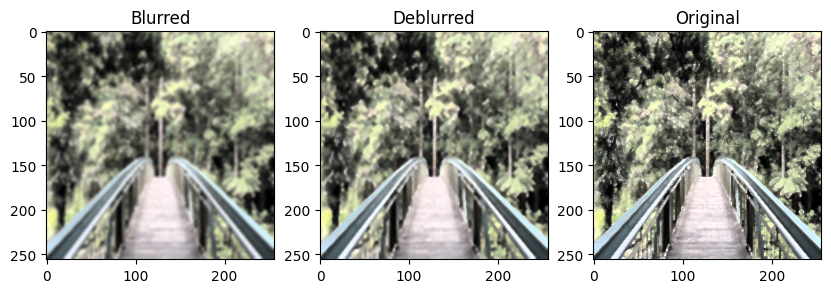

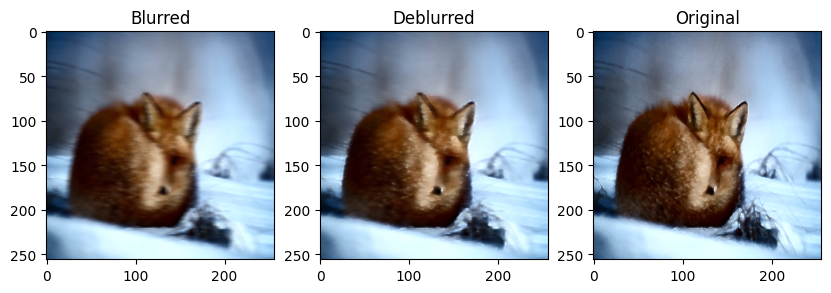

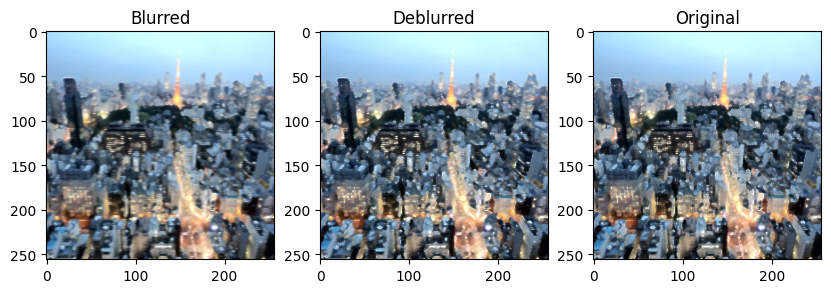

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step


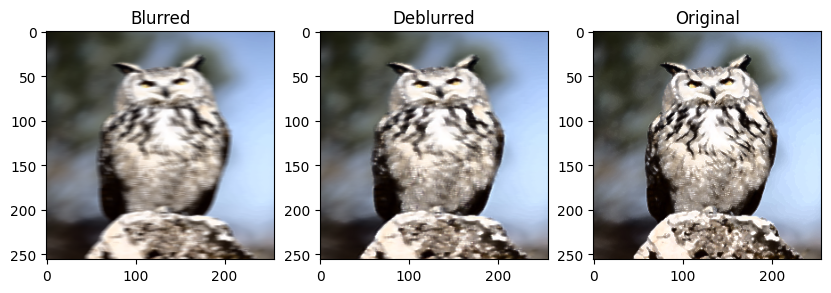

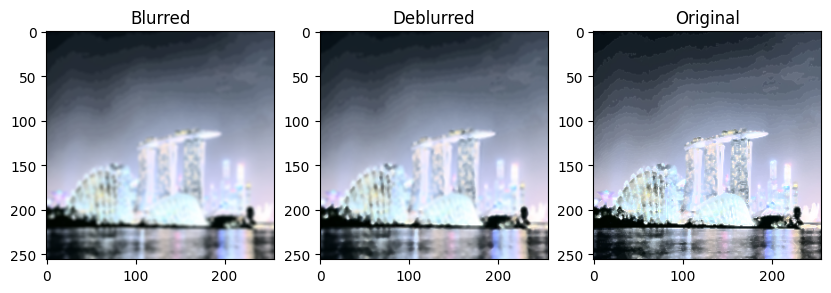

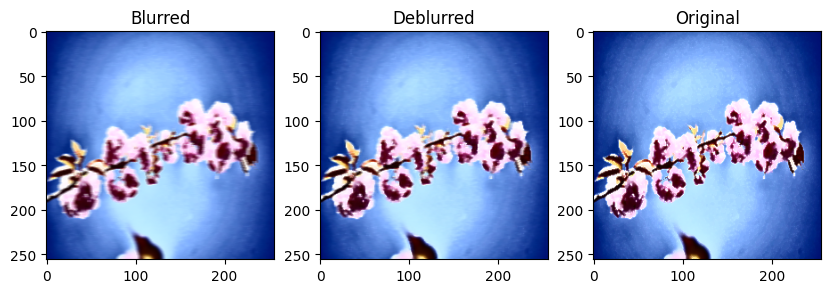

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


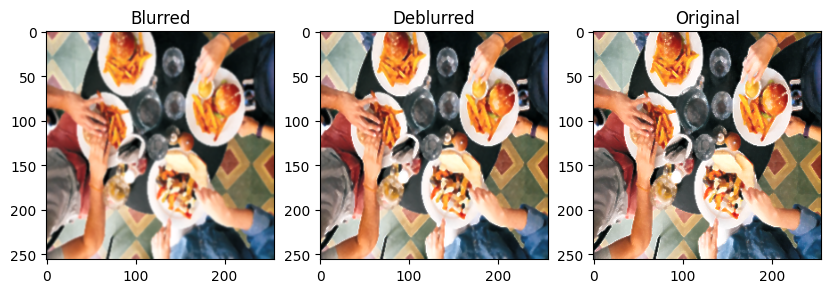

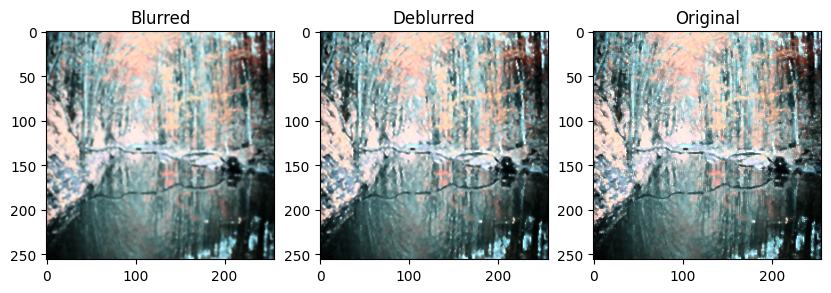

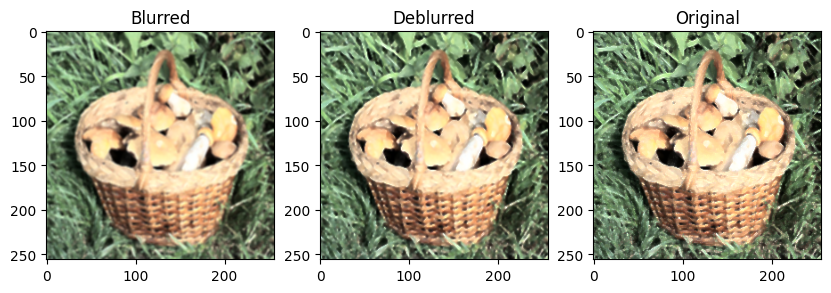

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


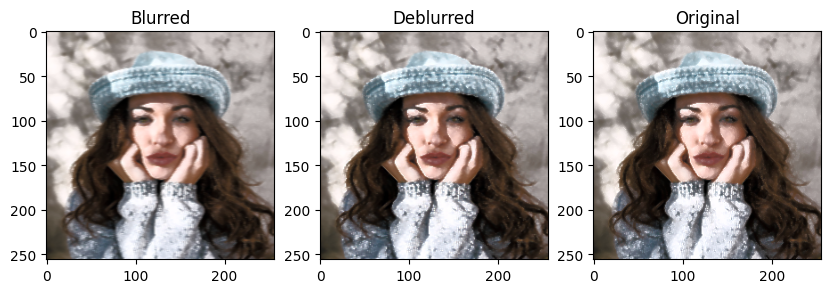

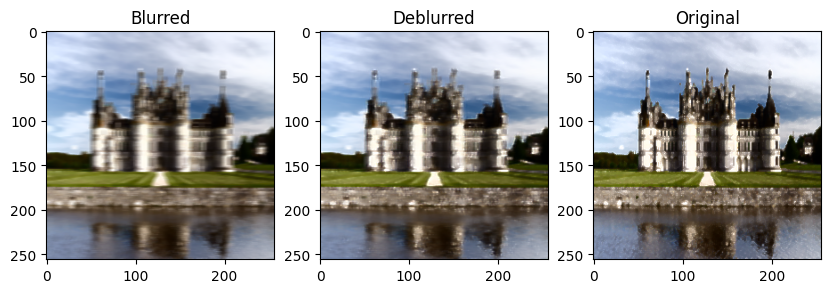

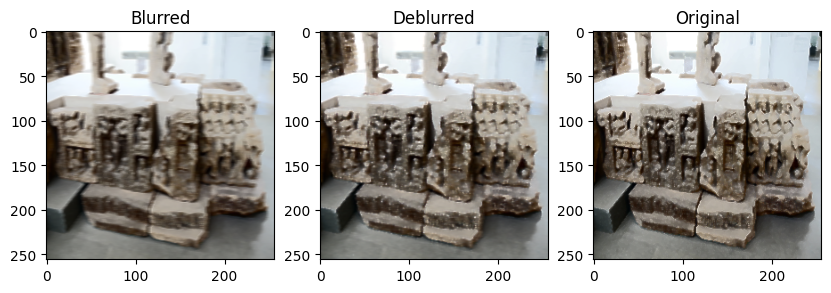

Avg PSNR: 28.68 dB | Avg SSIM: 0.911


In [24]:
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).batch(32)
evaluate_model(model, test_dataset, samples=4, num_images_per_batch_to_display=3)

Visualizing Loss over Training Period

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

Note: The original appears to be less detailed itself because when it was resized down to 128-128 pixels, it got pixelated. Therefore, when preprocess was applied over this pixelated version of the image, it created small blurs.

In [25]:
model.save("u-net_delur_256.keras")